Activating profile profile1

Realtime Websocket connection will use FEED: sip and credential of ACCOUNT1



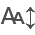

In [1]:
from v2realbot.tools.loadbatch import load_batch
from v2realbot.utils.utils import zoneNY
import pandas as pd
import numpy as np
import vectorbtpro as vbt
from itables import init_notebook_mode, show
import datetime
from itertools import product
from v2realbot.config import ACCOUNT1_PAPER_API_KEY, ACCOUNT1_PAPER_SECRET_KEY, DATA_DIR

init_notebook_mode(all_interactive=True)

vbt.settings.set_theme("dark")
vbt.settings['plotting']['layout']['width'] = 1280
vbt.settings.plotting.auto_rangebreaks = True
# Set the option to display with pagination
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_rows', 10)  # Number of rows per page

# Define the market open and close times
market_open = datetime.time(9, 30)
market_close = datetime.time(16, 0)
entry_window_opens = 1
entry_window_closes = 370

forced_exit_start = 380
forced_exit_end = 390

#LOAD FROM PARQUET
#list all files is dir directory with parquet extension
dir = DATA_DIR + "/notebooks/"
import os
files = [f for f in os.listdir(dir) if f.endswith(".parquet")]
#print('\n'.join(map(str, files)))
file_name = "ohlcv_df-SPY-2024-01-01T09:30:00-2024-05-14T16:00:00.parquet"
ohlcv_df = pd.read_parquet(dir+file_name,engine='pyarrow')
basic_data = vbt.Data.from_data(vbt.symbol_dict({"SPY": ohlcv_df}), tz_convert=zoneNY)

In [ ]:
#parameters (primary y line, secondary y line, close)
def plot_2y_close(priminds, secinds, close):
    fig = vbt.make_subplots(rows=1, cols=1, shared_xaxes=True, specs=[[{"secondary_y": True}]], vertical_spacing=0.02, subplot_titles=("MOM", "Price" ))
    close.vbt.plot(fig=fig, add_trace_kwargs=dict(secondary_y=False), trace_kwargs=dict(line=dict(color="blue")))
    for ind in priminds:
        ind.plot(fig=fig, add_trace_kwargs=dict(secondary_y=False))
    for ind in secinds:
        ind.plot(fig=fig, add_trace_kwargs=dict(secondary_y=True))
    return fig

# close = basic_data.xloc["09:30":"10:00"].close

In [4]:
#PIPELINE - FOR - LOOP

#indicator parameters
mom_timeperiod = list(range(2, 12))

#uzavreni okna od 1 do 200
#entry_window_closes = list(range(2, 50, 3))
entry_window_closes = [5, 10, 30, 45]
#entry_window_closes = 30
#threshold  entries parameters
#long
mom_th = np.round(np.arange(0.01, 0.5 + 0.02, 0.02),4).tolist()#-0.02
# short
#mom_th = np.round(np.arange(-0.01, -0.3 - 0.02, -0.02),4).tolist()#-0.02
roc_th = np.round(np.arange(-0.2, -0.8 - 0.05, -0.05),4).tolist()#-0.2
#print(mom_th, roc_th)

#portfolio simulation parameters
sl_stop =np.round(np.arange(0.02/100, 0.7/100, 0.05/100),4).tolist()
tp_stop = np.round(np.arange(0.02/100, 0.7/100, 0.05/100),4).tolist()

combs = list(product(mom_timeperiod, mom_th, roc_th, sl_stop, tp_stop))

@vbt.parameterized(merge_func = "concat", random_subset = 2000, show_progress=True)  
def test_strat(entry_window_closes=60,
               mom_timeperiod=2,
               mom_th=-0.04,
               #roc_th=-0.2,
               sl_stop=0.19/100,
               tp_stop=0.19/100):
    # mom_timeperiod=2
    # mom_th=-0.06
    # roc_th=-0.2
    # sl_stop=0.04/100
    # tp_stop=0.04/100

    momshort = vbt.indicator("talib:MOM").run(basic_data.close, timeperiod=mom_timeperiod, short_name = "slope_short")
    rocp = vbt.indicator("talib:ROC").run(basic_data.close, short_name = "rocp")
    #rate of change + momentum

    #momshort.plot rocp.real_crossed_below(roc_th) & 
    #short_signal = momshort.real_crossed_below(mom_th)
    long_signal = momshort.real_crossed_above(mom_th)
    # print("short signal")
    # print(short_signal.value_counts())

    #forced_exit = pd.Series(False, index=close.index)
    forced_exit = basic_data.symbol_wrapper.fill(False)
    #entry_window_open = pd.Series(False, index=close.index)
    entry_window_open=  basic_data.symbol_wrapper.fill(False)

    #print(entry_window_closes, "entry window closes")
    # Calculate the time difference in minutes from market open for each timestamp
    elapsed_min_from_open = (forced_exit.index.hour - market_open.hour) * 60 + (forced_exit.index.minute - market_open.minute)

    entry_window_open[(elapsed_min_from_open >= entry_window_opens) & (elapsed_min_from_open < entry_window_closes)] = True

    #print(entry_window_open.value_counts())

    forced_exit[(elapsed_min_from_open >= forced_exit_start) & (elapsed_min_from_open < forced_exit_end)] = True
    #short_entries = (short_signal & entry_window_open)
    #short_exits = forced_exit
    entries = (long_signal & entry_window_open)
    exits = forced_exit
    #long_entries.info()
    #number of trues and falses in long_entries
    #print(short_exits.value_counts())
    #print(short_entries.value_counts())

    #fig = plot_2y_close([],[momshort, rocp], close)
    #short_signal.vbt.signals.plot_as_entries(close, fig=fig, add_trace_kwargs=dict(secondary_y=False))
    #print(sl_stop)
    #tsl_th=sl_stop, 
    #short_entries=short_entries, short_exits=short_exits,
    pf = vbt.Portfolio.from_signals(close=basic_data.close, entries=entries, exits=exits, tsl_stop=sl_stop, tp_stop = tp_stop, fees=0.0167/100, freq="1s", price="close") #sl_stop=sl_stop, tp_stop = sl_stop,
    
    return pf.stats([
        'total_return',
        'max_dd', 
        'total_trades', 
        'win_rate', 
        'expectancy'
    ])

pf_results = test_strat(vbt.Param(entry_window_closes),
                        vbt.Param(mom_timeperiod),
                        vbt.Param(mom_th),
                        #vbt.Param(roc_th)
                        vbt.Param(sl_stop),
                        vbt.Param(tp_stop, condition="tp_stop > sl_stop"))
pf_results = pf_results.unstack(level=-1)
pf_results.sort_values(by=["Total Return [%]", "Max Drawdown [%]"], ascending=[False, True])


  0%|          | 0/2000 [00:00<?, ?it/s]

Total Return [%]  \
entry_window_closes mom_timeperiod mom_th sl_stop tp_stop                    
45                  6              0.27   0.0062  0.0067          3.969612   
                    4              0.27   0.0047  0.0067          3.460137   
                    11             0.31   0.0037  0.0057          3.140355   
                                   0.37   0.0047  0.0067          3.135768   
                    7              0.31   0.0047  0.0062          2.973553   
...                                                                    ...   
                    8              0.03   0.0002  0.0027        -76.759273   
                    9              0.03   0.0002  0.0007        -77.608633   
                    8              0.01   0.0002  0.0062        -78.904337   
                    4              0.03   0.0002  0.0047        -79.812711   
                    3              0.01   0.0002  0.0037        -83.687503   

                                                          Max Drawdown [%]  \
entry_window_closes mom_timeperiod mom_th sl_stop tp_stop                    
45                  6              0.27   0.0062  0.0067          2.187609   
                    4              0.27   0.0047  0.0067          1.270021   
                    11             0.31   0.0037  0.0057            1.5553   
                                   0.37   0.0047  0.0067          1.372389   
                    7              0.31   0.0047  0.0062          1.324725   
...                                                                    ...   
                    8              0.03   0.0002  0.0027         76.759273   
                    9              0.03   0.0002  0.0007         77.608633   
                    8              0.01   0.0002  0.0062         78.904337   
                    4              0.03   0.0002  0.0047          79.81415   
                    3              0.01   0.0002  0.0037         83.687503   

                                                          Total Trades  \
entry_window_closes mom_timeperiod mom_th sl_stop tp_stop                
45                  6              0.27   0.0062  0.0067            29   
                    4              0.27   0.0047  0.0067            21   
                    11             0.31   0.0037  0.0057            40   
                                   0.37   0.0047  0.0067            22   
                    7              0.31   0.0047  0.0062            24   
...                                                                ...   
                    8              0.03   0.0002  0.0027          4740   
                    9              0.03   0.0002  0.0007          4786   
                    8              0.01   0.0002  0.0062          5065   
                    4              0.03   0.0002  0.0047          5245   
                    3              0.01   0.0002  0.0037          5933   

                                                          Win Rate [%]  \
entry_window_closes mom_timeperiod mom_th sl_stop tp_stop                
45                  6              0.27   0.0062  0.0067      58.62069   
                    4              0.27   0.0047  0.0067     61.904762   
                    11             0.31   0.0037  0.0057          52.5   
                                   0.37   0.0047  0.0067     54.545455   
                    7              0.31   0.0047  0.0062     54.166667   
...                                                                ...   
                    8              0.03   0.0002  0.0027     11.118143   
                    9              0.03   0.0002  0.0007      10.80234   
                    8              0.01   0.0002  0.0062     11.273445   
                    4              0.03   0.0002  0.0047     11.325071   
                    3              0.01   0.0002  0.0037      11.22535   

                                                          Expectancy  
entry_window_closes mom_timeper

In [3]:
#pf_results.load("10tiscomb.pickle")
#pf_results.info()

vbt.save(pf_results, "8tiscomb_tsl.pickle")

# pf_results = vbt.load("8tiscomb_tsl.pickle")
# pf_results


PosixPath('8tiscomb_tsl.pickle')

In [13]:
# parallel_coordinates method¶

# attach_px_methods.<locals>.plot_func(
#     *args,
#     layout=None,
#     **kwargs
# )

# pf_results.vbt.px.parallel_coordinates() #ocdf

res = pf_results.reset_index()

AttributeError: 'PXDFAccessor' object has no attribute 'pairplot'

In [ ]:
pf_results

entry_window_closes  mom_timeperiod  mom_th  sl_stop  tp_stop  \
0                       3               2   -0.31   0.0003   0.0018   
1                       3               2   -0.31   0.0003   0.0068   
2                       3               2   -0.31   0.0013   0.0028   
3                       3               2   -0.31   0.0013   0.0058   
4                       3               2   -0.31   0.0018   0.0038   
...                   ...             ...     ...      ...      ...   
7995                   70              11   -0.01   0.0003   0.0018   
7996                   70              11   -0.01   0.0003   0.0038   
7997                   70              11   -0.01   0.0028   0.0038   
7998                   70              11   -0.01   0.0033   0.0053   
7999                   70              11   -0.01   0.0038   0.0053   

     Total Return [%] Max Drawdown [%] Total Trades Win Rate [%] Expectancy  
0                 0.0              NaN            0          NaN        NaN  
1                 0.0              NaN            0          NaN        NaN  
2                 0.0              NaN            0          NaN        NaN  
3                 0.0              NaN            0          NaN        NaN  
4                 0.0              NaN            0          NaN        NaN  
...               ...              ...          ...          ...        ...  
7995       -60.724025        60.747552         4025    23.701863  -0.015087  
7996       -59.557376        59.581603         4017    23.749066  -0.014826  
7997       -13.574229        16.599702          451    33.259424  -0.030098  
7998        -9.970892        14.327723          338    34.023669    -0.0295  
7999        -7.135743        12.027996          280    34.642857  -0.025485  

[8000 rows x 10 columns]

In [15]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming pf_results is your DataFrame
# Convert columns to numeric, assuming NaNs where conversion fails
metrics = ['Total Return [%]', 'Max Drawdown [%]', 'Total Trades']
for metric in metrics:
    pf_results[metric] = pd.to_numeric(pf_results[metric], errors='coerce')

# Handle missing values, for example filling with the median
pf_results['Max Drawdown [%]'].fillna(pf_results['Max Drawdown [%]'].median(), inplace=True)

# Extract the metrics into a new DataFrame
data_for_pca = pf_results[metrics]

# Standardize the data before applying PCA
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_pca)

# Apply PCA
pca = PCA(n_components=2)  # Adjust components as needed
principal_components = pca.fit_transform(data_scaled)

# Create a DataFrame with the principal components
pca_results = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Visualize the results
plt.figure(figsize=(8,6))
plt.scatter(pca_results['PC1'], pca_results['PC2'], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Strategy Optimization Results')
plt.grid(True)
plt.savefig("ddd.png")


/var/folders/8p/dwqnp65s0s77jdbm4_6z4vp80000gn/T/ipykernel_3935/927237224.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pf_results['Max Drawdown [%]'].fillna(pf_results['Max Drawdown [%]'].median(), inplace=True)


In [ ]:
# Check if there is any unnamed level and rename it
if None in df.index.names:
    # Generate new names list replacing None with 'stat'
    new_names = ['stat' if name is None else name for name in df.index.names]
    df.index.set_names(new_names, inplace=True)

rs= df

rs.info()


# # Now, 'stat' is the name of the previously unnamed level

# # Filter for 'Total Return' assuming it is a correct identifier in the 'stat' level
# total_return_series = df.xs('Total Return [%]', level='stat')

# # Sort the Series to get the largest 'Total Return' values
# sorted_series = total_return_series.sort_values(ascending=False)

# # Print the sorted filtered data
# sorted_series.head(20)

In [ ]:
sorted_series.vbt.save()

In [ ]:
#df.info()
total_return_series = df.xs('Total Return [%]')
sorted_series = total_return_series.sort_values(ascending=False)

# Display the top N entries, e.g., top 5
sorted_series.head(5)

In [ ]:
df

In [ ]:
comb_stats_df.nlargest(10, 'Total Return [%]')
#stats_df.info()


8	-0.06	-0.2	0.0028	0.0048	4.156254
4               -0.02   -0.25   0.0028   0.0048      0.84433
3   -0.02   -0.25   0.0033   0.0023   Total Return [%]     0.846753
#2	-0.04	-0.2	0.0019	0.0019
# 2	-0.04	-0.2	0.0019	0.0019	0.556919	91	60.43956	0.00612
# 2	-0.04	-0.25	0.0019	0.0019	0.556919	91	60.43956	0.00612
# 2	-0.04	-0.3	0.0019	0.0019	0.556919	91	60.43956	0.00612
# 2	-0.04	-0.35	0.0019	0.0019	0.556919	91	60.43956	0.00612
# 2	-0.04	-0.4	0.0019	0.0019	0.556919	91	60.43956	0.00612
# 2	-0.04	-0.2	0.0019	0.0017	0.451338	93	63.44086	0.004853
# 2	-0.04	-0.25	0.0019	0.0017	0.451338	93	63.44086	0.004853
# 2	-0.04	-0.3	0.0019	0.0017	0.451338	93	63.44086	0.004853
# 2	-0.04	-0.35	0.0019	0.0017	0.451338	93	63.44086	0.004853
# 2	-0.04	-0.4	0.0019	0.0017	0.451338	93	63.44086	0.004853

In [ ]:
pf.plot()

In [ ]:
basic_data.symbols

In [ ]:
>>> def apply_func(ts, entries, exits, fastw, sloww, minp=None):
...     fast_ma = vbt.nb.rolling_mean_nb(ts, fastw, minp=minp)
...     slow_ma = vbt.nb.rolling_mean_nb(ts, sloww, minp=minp)
...     entries[:] = vbt.nb.crossed_above_nb(fast_ma, slow_ma)  
...     exits[:] = vbt.nb.crossed_above_nb(slow_ma, fast_ma)
...     return (fast_ma, slow_ma)  

>>> CrossSig = vbt.IF(
...     class_name="CrossSig",
...     input_names=['ts'],
...     in_output_names=['entries', 'exits'],
...     param_names=['fastw', 'sloww'],
...     output_names=['fast_ma', 'slow_ma']
... ).with_apply_func(
...     apply_func,
...     in_output_settings=dict(
...         entries=dict(dtype=np.bool_),  #initialize output with bool
...         exits=dict(dtype=np.bool_)
...     )
... )
>>> cross_sig = CrossSig.run(ts2, 2, 4)

In [ ]:
#PIPELINE - parameters in one go


#TOTO prepsat do FOR-LOOPu


#indicator parameters
mom_timeperiod = list(range(2, 6))

#threshold  entries parameters
mom_th = np.round(np.arange(-0.02, -0.1 - 0.02, -0.02),4).tolist()#-0.02
roc_th = np.round(np.arange(-0.2, -0.4 - 0.05, -0.05),4).tolist()#-0.2
#print(mom_th, roc_th)
#jejich product
# mom_th_prod, roc_th_prod = zip(*product(mom_th, roc_th))

# #convert threshold to vbt param
# mom_th_index = vbt.Param(mom_th_prod, name='mom_th_th') 
# roc_th_index = vbt.Param(roc_th_prod, name='roc_th_th')

mom_th = vbt.Param(mom_th, name='mom_th')
roc_th = vbt.Param(roc_th, name='roc_th')

#portfolio simulation parameters
sl_stop = np.arange(0.03/100, 0.2/100, 0.02/100).tolist()
# Using the round function
sl_stop = [round(val, 4) for val in sl_stop]
tp_stop = np.arange(0.03/100, 0.2/100, 0.02/100).tolist()
# Using the round function
tp_stop = [round(val, 4) for val in tp_stop]
sl_stop = vbt.Param(sl_stop) #np.nan mean s no stoploss
tp_stop = vbt.Param(tp_stop) #np.nan mean s no stoploss


#def test_mom(window=14, mom_th=0.2, roc_th=0.2, sl_stop=0.03/100, tp_stop=0.03/100):
#close = basic_data.xloc["09:30":"10:00"].close
momshort = vbt.indicator("talib:MOM").run(basic_data.get("Close"), timeperiod=mom_timeperiod, short_name = "slope_short")

#ht_trendline = vbt.indicator("talib:HT_TRENDLINE").run(close, short_name = "httrendline")
rocp = vbt.indicator("talib:ROC").run(basic_data.get("Close"), short_name = "rocp")
#rate of change + momentum

rocp_signal = rocp.real_crossed_below(mom_th)
mom_signal = momshort.real_crossed_below(roc_th)

#mom_signal
print(rocp_signal.info())
print(mom_signal.info())
#print(rocp.real)


short_signal = (mom_signal.vbt & rocp_signal)

# #short_signal = (rocp.real_crossed_below(roc_th_index) & momshort.real_crossed_below(mom_th_index))
# forced_exit = m1_data.symbol_wrapper.fill(False)
# entry_window_open=  m1_data.symbol_wrapper.fill(False)


# # Calculate the time difference in minutes from market open for each timestamp
# elapsed_min_from_open = (forced_exit.index.hour - market_open.hour) * 60 + (forced_exit.index.minute - market_open.minute)

# entry_window_open[(elapsed_min_from_open >= entry_window_opens) & (elapsed_min_from_open < entry_window_closes)] = True
# forced_exit[(elapsed_min_from_open >= forced_exit_start) & (elapsed_min_from_open < forced_exit_end)] = True
# short_entries = (short_signal & entry_window_open)
# short_exits = forced_exit
# #long_entries.info()
# #number of trues and falses in long_entries
# #short_exits.value_counts()
# #short_entries.value_counts()


# pf = vbt.Portfolio.from_signals(close=close, short_entries=short_entries, short_exits=short_exits, sl_stop=sl_stop, tp_stop = tp_stop, fees=0.0167/100, freq="1s") #sl_stop=sl_stop, tp_stop = sl_stop,



# filter dates

In [ ]:
#filter na dny
dates_of_interest = pd.to_datetime(['2024-04-22']).tz_localize('US/Eastern')
filtered_df = df.loc[df.index.normalize().isin(dates_of_interest)]

df = filtered_df
df.info()

In [ ]:
# import plotly.io as pio
# pio.renderers.default = 'notebook'

#naloadujeme do vbt symbol as column
basic_data = vbt.Data.from_data({"BAC": df}, tz_convert=zoneNY)

vbt.settings.plotting.auto_rangebreaks = True
#basic_data.data["BAC"].vbt.ohlcv.plot()

#basic_data.data["BAC"]

In [ ]:
m1_data = basic_data[['Open', 'High', 'Low', 'Close', 'Volume']]

m1_data.data["BAC"]
#m5_data = m1_data.resample("5T")

#m5_data.data["BAC"].head(10)

# m15_data = m1_data.resample("15T")

# m15 = m15_data.data["BAC"]

# m15.vbt.ohlcv.plot()

# m1_data.wrapper.index

# m1_resampler = m1_data.wrapper.get_resampler("1T")
# m1_resampler.index_difference(reverse=True)


# m5_resampler.prettify()

# MOM indicator

In [ ]:
vbt.phelp(vbt.indicator("talib:ROCP").run)

vyuzití rychleho klesani na sekundove urovni behem open rush
- MOM + ROC during open rush
- short signal
- pipeline kombinace thresholdu pro vstup mom_th, roc_th + hodnota sl_stop a tp_stop (pripadne trailing) - nalezeni optimalni kombinace atributu

In [ ]:
# fig = plot_2y_close([ht_trendline],[momshort, rocp], close)
# short_signal.vbt.signals.plot_as_entries(close, fig=fig, add_trace_kwargs=dict(secondary_y=False))   

#parameters (primary y line, secondary y line, close)
def plot_2y_close(priminds, secinds, close):
    fig = vbt.make_subplots(rows=1, cols=1, shared_xaxes=True, specs=[[{"secondary_y": True}]], vertical_spacing=0.02, subplot_titles=("MOM", "Price" ))
    close.vbt.plot(fig=fig, add_trace_kwargs=dict(secondary_y=False), trace_kwargs=dict(line=dict(color="blue")))
    for ind in priminds:
        ind.plot(fig=fig, add_trace_kwargs=dict(secondary_y=False))
    for ind in secinds:
        ind.plot(fig=fig, add_trace_kwargs=dict(secondary_y=True))
    return fig

close = m1_data.xloc["09:30":"10:00"].close
momshort = vbt.indicator("talib:MOM").run(close, timeperiod=3, short_name = "slope_short")
ht_trendline = vbt.indicator("talib:HT_TRENDLINE").run(close, short_name = "httrendline")
rocp = vbt.indicator("talib:ROC").run(close, short_name = "rocp")
#rate of change + momentum
short_signal = (rocp.real_crossed_below(-0.2) & momshort.real_crossed_below(-0.02))
#indlong = vbt.indicator("talib:MOM").run(close, timeperiod=10, short_name = "slope_long")
fig = plot_2y_close([ht_trendline],[momshort, rocp], close)
short_signal.vbt.signals.plot_as_entries(close, fig=fig, add_trace_kwargs=dict(secondary_y=False))   

In [ ]:
close = m1_data.close
#vbt.phelp(vbt.OLS.run)

#oer steepmnes of regression line
#talib.LINEARREG_SLOPE(close, timeperiod=timeperiod)
#a také ON BALANCE VOLUME - http://5.161.179.223:8000/static/js/vbt/api/indicators/custom/obv/index.html



mom_ind = vbt.indicator("talib:MOM") 
#vbt.phelp(mom_ind.run)

mom = mom_ind.run(close, timeperiod=10)

plot_2y_close(mom, close)

# defining ENTRY WINDOW and forced EXIT window

In [ ]:
#m1_data.data["BAC"].info()
import datetime
# Define the market open and close times
market_open = datetime.time(9, 30)
market_close = datetime.time(16, 0)
entry_window_opens = 2
entry_window_closes = 30

forced_exit_start = 380
forced_exit_end = 390

forced_exit = m1_data.symbol_wrapper.fill(False)
entry_window_open=  m1_data.symbol_wrapper.fill(False)

# Calculate the time difference in minutes from market open for each timestamp
elapsed_min_from_open = (forced_exit.index.hour - market_open.hour) * 60 + (forced_exit.index.minute - market_open.minute)

entry_window_open[(elapsed_min_from_open >= entry_window_opens) & (elapsed_min_from_open < entry_window_closes)] = True
forced_exit[(elapsed_min_from_open >= forced_exit_start) & (elapsed_min_from_open < forced_exit_end)] = True

#entry_window_open.info()
# forced_exit.tail(100)

In [ ]:
close = m1_data.close

#rsi = vbt.RSI.run(close, window=14)

short_entries = (short_signal & entry_window_open)
short_exits = forced_exit
#long_entries.info()
#number of trues and falses in long_entries
#short_exits.value_counts()
short_entries.value_counts()

In [ ]:
def plot_rsi(close, entries, exits):
    fig = vbt.make_subplots(rows=1, cols=1, shared_xaxes=True, specs=[[{"secondary_y": True}]], vertical_spacing=0.02, subplot_titles=("RSI", "Price" ))
    close.vbt.plot(fig=fig, add_trace_kwargs=dict(secondary_y=True))
    #rsi.plot(fig=fig, add_trace_kwargs=dict(secondary_y=False))
    entries.vbt.signals.plot_as_entries(close, fig=fig, add_trace_kwargs=dict(secondary_y=False))  
    exits.vbt.signals.plot_as_exits(close, fig=fig, add_trace_kwargs=dict(secondary_y=False))  
    return fig

plot_rsi(close, short_entries, short_exits)


In [ ]:
vbt.phelp(vbt.Portfolio.from_signals)

In [ ]:
sl_stop = np.arange(0.03/100, 0.2/100, 0.02/100).tolist()
# Using the round function
sl_stop = [round(val, 4) for val in sl_stop]
print(sl_stop)
sl_stop = vbt.Param(sl_stop) #np.nan mean s no stoploss

pf = vbt.Portfolio.from_signals(close=close, short_entries=short_entries, short_exits=short_exits, sl_stop=0.03/100, tp_stop = 0.03/100, fees=0.0167/100, freq="1s") #sl_stop=sl_stop, tp_stop = sl_stop,

#pf.stats()

In [ ]:
#list of orders
#pf.orders.records_readable
#pf.orders.plots()
#pf.stats()
pf.stats()

In [ ]:
pf.plot()

In [ ]:
pf[(0.0015,0.0013)].plot()

In [ ]:
pf[0.03].plot_trade_signals()


# pristup k pf jako multi index

In [ ]:
#pf[0.03].plot()
#pf.order_records
pf[(0.03)].stats()

In [ ]:
#zgrupovane statistiky
stats_df = pf.stats([
    'total_return',
    'total_trades',
    'win_rate',
    'expectancy'
], agg_func=None)
stats_df


stats_df.nlargest(10, 'Total Return [%]')
#stats_df.info()

In [ ]:
pf[(0.0011,0.0013000000000000002)].plot()

In [ ]:
from pandas.tseries.offsets import DateOffset

temp_data = basic_data['2024-4-22']
temp_data
res1m = temp_data[["Open", "High", "Low", "Close", "Volume"]]

# Define a custom date offset that starts at 9:30 AM and spans 4 hours
custom_offset = DateOffset(hours=4, minutes=30)

# res1m = res1m.get().resample("4H").agg({  
#     "Open": "first",
#     "High": "max",
#     "Low": "min",
#     "Close": "last",
#     "Volume": "sum"
# })

res4h = res1m.resample("1h", resample_kwargs=dict(origin="start"))

res4h.data

res15m = res1m.resample("15T", resample_kwargs=dict(origin="start"))

res15m.data["BAC"]

In [ ]:
@vbt.njit
def long_entry_place_func_nb(c, low, close, time_in_ns, rsi14, window_open, window_close):
    market_open_minutes = 570  # 9 hours * 60 minutes + 30 minutes

    for out_i in range(len(c.out)):
        i = c.from_i + out_i

        current_minutes = vbt.dt_nb.hour_nb(time_in_ns[i]) * 60 + vbt.dt_nb.minute_nb(time_in_ns[i])
        #print("current_minutes", current_minutes)
        # Calculate elapsed minutes since market open at 9:30 AM
        elapsed_from_open = current_minutes - market_open_minutes
        elapsed_from_open = elapsed_from_open if elapsed_from_open >= 0 else 0
        #print( "elapsed_from_open", elapsed_from_open)

        #elapsed_from_open = elapsed_minutes_from_open_nb(time_in_ns) 
        in_window = elapsed_from_open > window_open and elapsed_from_open < window_close
        #print("in_window", in_window)
        # if in_window:
        #     print("in window")

        if in_window and rsi14[i] > 60: # and low[i, c.col] <= hit_price: # and hour == 9:  # (4)!
            return out_i
    return -1

@vbt.njit
def long_exit_place_func_nb(c, high, close, time_index, tp, sl):  # (5)!
    entry_i = c.from_i - c.wait
    entry_price = close[entry_i, c.col]
    hit_price = entry_price * (1 + tp)
    stop_price = entry_price * (1 - sl)
    for out_i in range(len(c.out)):
        i = c.from_i + out_i
        last_bar_of_day = vbt.dt_nb.day_changed_nb(time_index[i], time_index[i + 1])

        #print(next_day)
        if last_bar_of_day: #pokud je dalsi next day, tak zavirame posledni
            print("ted",out_i)
            return out_i
        if close[i, c.col] >= hit_price or close[i, c.col] <= stop_price :
            return out_i
    return -1




In [ ]:
df = pd.DataFrame(np.random.random(size=(5, 10)), columns=list('abcdefghij'))

df

In [ ]:
df.sum()